<a href="https://colab.research.google.com/github/Koftarik/Data_Processing_and_Machine_Learning/blob/main/3_Text_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Необходимо разработать программу, обеспечивающую кластеризацию новостного потока. Необходимо загрузить новостную ленту, указанную преподавателем, выделив из нее тематические пометы (при наличии). Далее следует векторизовать тексты, провести их кластеризацию и проверить точность кластеризации по тематическим пометам. Также следует выбрать один из кластеров и обучить на нем классификатор. Точность работы классификатора определяется при помощи f1-меры и матрицы ошибок.


In [ ]:
import re
from tqdm import tqdm
import pandas as pd
import csv
import matplotlib.pyplot as plt
import ast
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

plt.rcParams['figure.figsize'] = (12, 8)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
news0 = 'drive/MyDrive/Colab Notebooks/data/news (1).csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
news = pd.read_csv(news0)

In [ ]:
print(news.head())

                                              aTitle  \
0  С подачи шаманов. Ритуалы с употреблением галл...   
1  Куда и откуда. О миграции древних людей расска...   
2  Окончательно и бесповоротно? Предотвратить рец...   
3  Жжет светило. Наблюдения космического аппарата...   
4  Меняется обмен. Уникальный атлас отразил проце...   

                                        categories  \
0    ['Новости', 'В мире', 'Статьи', 'Археология']   
1    ['Новости', 'В мире', 'Статьи', 'Археология']   
2      ['Новости', 'В мире', 'Статьи', 'Медицина']   
3        ['Новости', 'В мире', 'Статьи', 'Космос']   
4  ['Новости', 'В России', 'Статьи', 'Социология']   

                                           anArticle  
0  Анализ пряди волос из могильника на испанском ...  
1  В мае в Таджикистане состоится масштабная эксп...  
2  Новая противораковая вакцина, подогнанная под ...  
3  В марте прошлого года, спустя несколько месяце...  
4  Уезжают, приезжают, перемещаются… Добровольно,...  


In [ ]:
news.iloc[2,:]

aTitle        Окончательно и бесповоротно? Предотвратить рец...
categories          ['Новости', 'В мире', 'Статьи', 'Медицина']
anArticle     Новая противораковая вакцина, подогнанная под ...
Name: 2, dtype: object

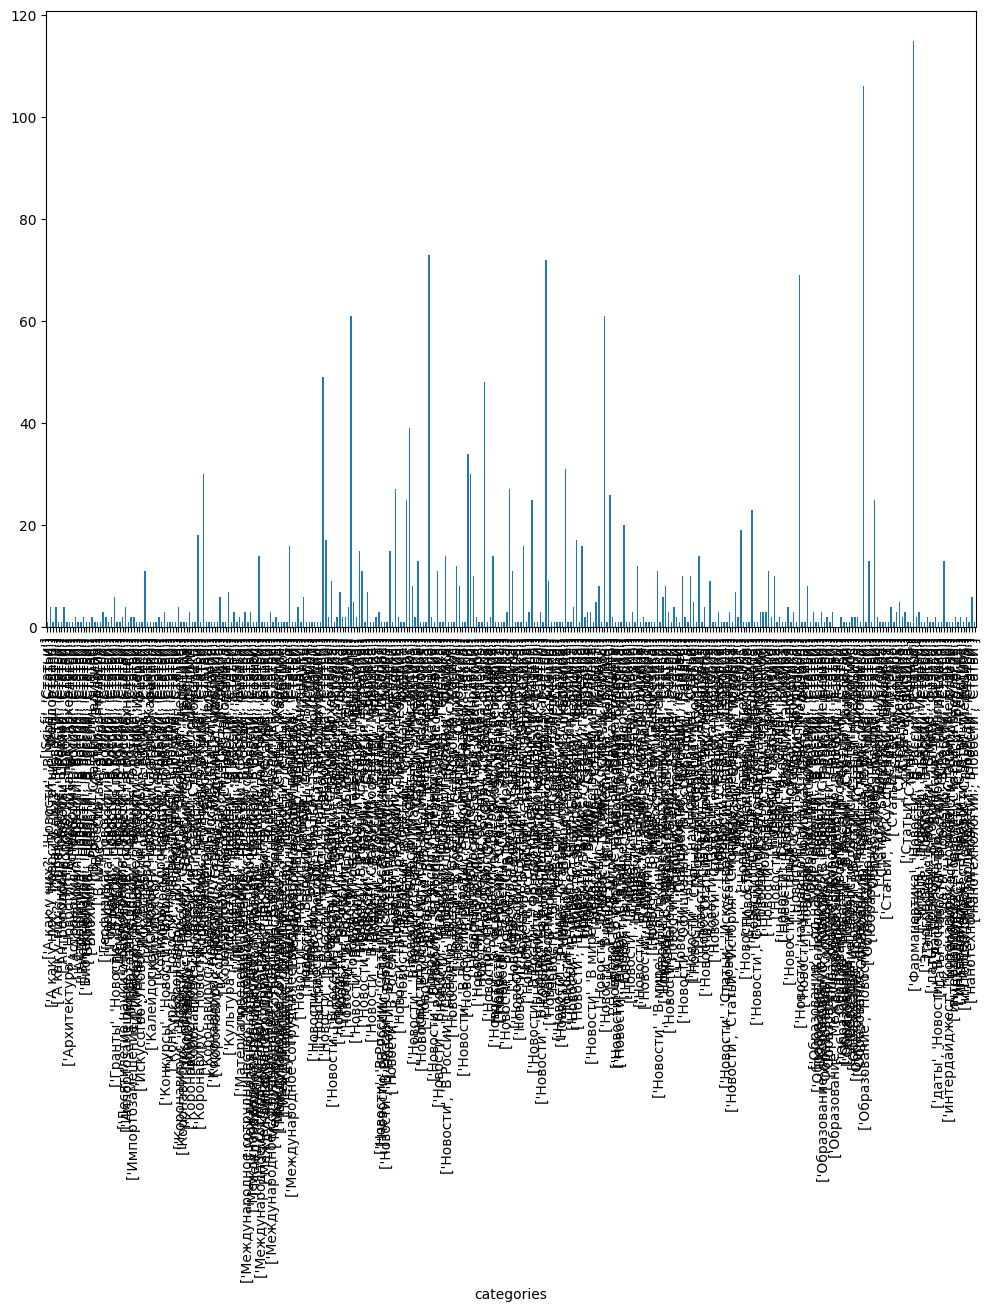

In [ ]:
text_summary = news.groupby('categories').count().drop('aTitle', axis=1)
ax = text_summary.plot.bar(y='anArticle') # Рисуем частоты.
ax.get_legend().remove() # Легенда всё равно только мешала.

In [ ]:
print(news.categories)

0         ['Новости', 'В мире', 'Статьи', 'Археология']
1         ['Новости', 'В мире', 'Статьи', 'Археология']
2           ['Новости', 'В мире', 'Статьи', 'Медицина']
3             ['Новости', 'В мире', 'Статьи', 'Космос']
4       ['Новости', 'В России', 'Статьи', 'Социология']
                             ...                       
1944                             ['Статьи', 'Медицина']
1945                                         ['Статьи']
1946                              ['Статьи', 'История']
1947                                         ['Статьи']
1948                  ['Статьи', 'Биология', 'История']
Name: categories, Length: 1949, dtype: object


In [ ]:
flat_list = [item for sublist in news.categories for item in sublist]
print(flat_list)

In [ ]:
tuple_list = [ast.literal_eval(x) for x in news.categories]

# объединяем все кортежи в один список
flat_list = [item for sublist in tuple_list for item in sublist]

# создаем множество уникальных значений и преобразуем его обратно в список
unique_list = list(set(flat_list))

# выводим список уникальных значений
print(unique_list)

['Экология', 'Психология', 'Этнография', 'интердайджест', 'Демография', 'Урбанистика', 'География', 'Биомедицина', 'Анонсы', 'Палеонтология', 'Просто о сложном', 'Международное сотрудничество', 'Новости', 'Геология', 'Техно', 'Калейдоскоп', 'Sci-fi', 'Необычная планета', 'Астрофизика', 'Кардиология', 'Космос', 'Юриспруденция', 'Память', 'Антропология', 'Выборы в РАН', 'Культура', 'Социология', 'Климат', 'Химия', 'Сейсмология', 'Биология', 'Обижают', 'Фондоотдача', 'Импортозамещение', 'Искусственный интеллект', 'В России', 'Литература', 'Математика', 'Геофизика', 'Искусство', 'Биохимия', 'Коронавирус', 'Зоология', 'Десятилетие науки и технологий', 'Официально', 'А как у них?', 'Материаловедение', 'Физика', 'научная политика', 'Эксперименты', 'русский язык', 'Энтомология', 'Награждения', 'Интернет', 'Гранты', 'Генетика', 'Археология', 'Технологии', 'Рейтинги', 'Биотехнологии', 'Карантин', 'нанотехнологии', 'Смотреть', 'РАН', 'СМИ', 'Экономика', 'Медицина', 'Территория науки', 'Год науки'

In [ ]:
news_by_category = {category: 0 for category in unique_list}

for index, row in news.iterrows():
    categories = eval(row['categories']) # распарсим строку с кортежем в список

    for category in categories: # пройдёмся по списку с категориями каждой новости
        if category in news_by_category:
            news_by_category[category] += 1 # увеличим счётчик, если категория есть в списке уникальных

print (len(news_by_category))
print(news_by_category)

86
{'Экология': 47, 'Психология': 21, 'Этнография': 3, 'интердайджест': 11, 'Демография': 3, 'Урбанистика': 3, 'География': 17, 'Биомедицина': 2, 'Анонсы': 1, 'Палеонтология': 39, 'Просто о сложном': 5, 'Международное сотрудничество': 53, 'Новости': 1794, 'Геология': 13, 'Техно': 42, 'Калейдоскоп': 5, 'Sci-fi': 1, 'Необычная планета': 3, 'Астрофизика': 1, 'Кардиология': 1, 'Космос': 132, 'Юриспруденция': 5, 'Память': 42, 'Антропология': 5, 'Выборы в РАН': 5, 'Культура': 5, 'Социология': 8, 'Климат': 42, 'Химия': 29, 'Сейсмология': 2, 'Биология': 129, 'Обижают': 5, 'Фондоотдача': 4, 'Импортозамещение': 6, 'Искусственный интеллект': 24, 'В России': 1116, 'Литература': 4, 'Математика': 17, 'Геофизика': 3, 'Искусство': 15, 'Биохимия': 2, 'Коронавирус': 96, 'Зоология': 6, 'Десятилетие науки и технологий': 4, 'Официально': 12, 'А как у них?': 10, 'Материаловедение': 4, 'Физика': 93, 'научная политика': 123, 'Эксперименты': 2, 'русский язык': 10, 'Энтомология': 1, 'Награждения': 11, 'Интернет

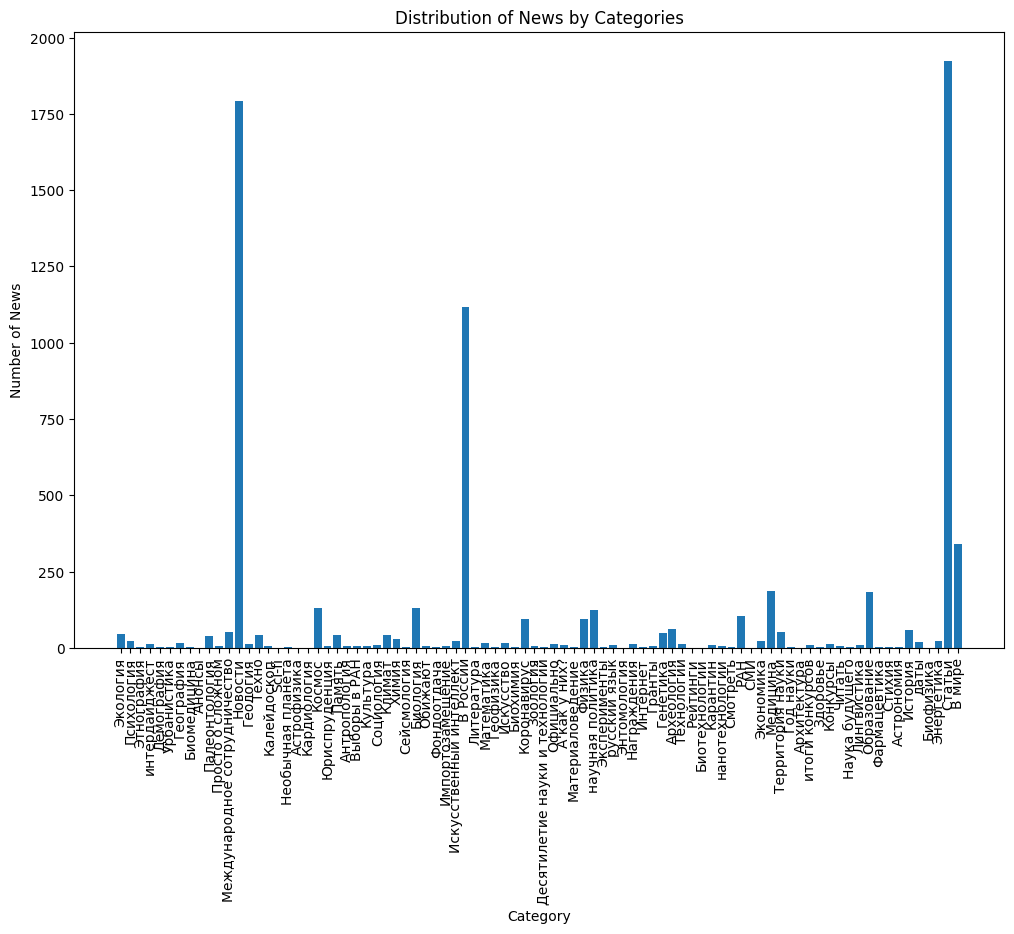

In [ ]:
# построение столбчатой диаграммы
plt.bar(news_by_category.keys(), news_by_category.values())

# добавление заголовка и меток осей
plt.title('Distribution of News by Categories')
plt.xlabel('Category')
plt.ylabel('Number of News')
plt.xticks(rotation=90)
# отображение графика
plt.show()

In [ ]:
# Среди прочего, можно указать регулярное выражение, которое будет выделять слова.
counter=CountVectorizer(token_pattern=r'[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+')
# Обратите внимание, передается список текстов.
res=counter.fit_transform([news.anArticle.iloc[0]])
print(counter.vocabulary_)

{'анализ': 10, 'пряди': 168, 'волос': 31, 'из': 61, 'могильника': 98, 'на': 103, 'испанском': 68, 'острове': 126, 'менорка': 95, 'показал': 147, 'что': 227, 'люди': 93, 'древней': 49, 'цивилизации': 224, 'использовали': 70, 'галлюциногены': 41, 'растительного': 177, 'происхождения': 165, 'это': 232, 'открытие': 128, 'первое': 136, 'прямое': 169, 'указание': 214, 'использование': 71, 'психоактивных': 171, 'веществ': 24, 'в': 21, 'европе': 52, 'исследователи': 74, 'под': 145, 'руководством': 182, 'элизы': 230, 'гуэрра-доче': 44, 'вальядолидского': 22, 'университета': 216, 'испании': 67, 'авторы': 6, 'статьи': 205, 'scientific': 2, 'reports': 1, 'определили': 125, 'присутствие': 161, 'скополамина': 191, 'эфедрина': 238, 'и': 59, 'атропина': 13, 'трех': 211, 'образцах': 117, 'атропин': 12, 'скополамин': 190, 'естественных': 54, 'условиях': 219, 'содержатся': 195, 'растениях': 176, 'семейства': 188, 'пасленовых': 134, 'могут': 101, 'вызывать': 37, 'бред': 17, 'галлюцинации': 40, 'изменять':

In [ ]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pymorphy2
import umap.umap_ as umap
from sklearn.metrics import adjusted_rand_score
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from sklearn.cluster import KMeans

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
modelvec = 'drive/MyDrive/Colab Notebooks/data/araneum_upos_skipgram_300_2_2018.vec.gz'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_w2v = KeyedVectors.load_word2vec_format(modelvec)
index2word_set = set(model_w2v.index_to_key)

In [ ]:
conv_pos = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN',
            'VERB':'VERB', 'PRTF':'ADJ', 'PRTS':'ADJ', 'GRND':'VERB'} #значимые части речи
tmp_dict = {} # Кеш значимых слов.
nones = {} # Кеш незначимых слов.

morph = pymorphy2.MorphAnalyzer()

In [ ]:
# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy(text, need_pos=True):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        # Если токен уже был закеширован, быстро возьмем результат из него.
        if t in tmp_dict.keys():
            words.append(tmp_dict[t])
        # Аналогично, если он в кеше незначимых слов.
        elif t in nones.keys():
            pass
        # Слово еще не встретилось, будем проводить медленный морфологический анализ.
        else:
            pv = morph.parse(t)
            if pv[0].tag.POS != None:
                if pv[0].tag.POS in conv_pos.keys():
                    if need_pos:
                        word = pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS]
                    else:
                        word = pv[0].normal_form
                    # Отправляем слово в результат, ...
                    words.append(word)
                    # ... и кешируем результат его разбора.
                    tmp_dict[t] = word
                else:
                    # Для незначимых слов можно даже ничего не хранить. Лишь бы потом не обращаться к морфологии.
                    nones[t] = ""

    return words

In [ ]:
#создадим функцию векторизации текста
def text_to_vec(text):
    text_vec = np.zeros((model_w2v.vector_size,), dtype="float32")
    n_words = 0

    for word in normalizePymorphy(text):
        if word in index2word_set:
            n_words = n_words + 1
            text_vec = np.add(text_vec, model_w2v[word])

    if n_words != 0:
        text_vec /= n_words
    return text_vec

In [ ]:
news['anArticle'] = news['anArticle'].apply(str)

In [ ]:
texts = []
for text in news.anArticle:
    texts.append(normalizePymorphy(text))

In [ ]:
w2v_vectors = [text_to_vec(text) for text in news['anArticle']]
umap_news = umap.UMAP()
umaped_vct = umap_news.fit_transform(w2v_vectors)

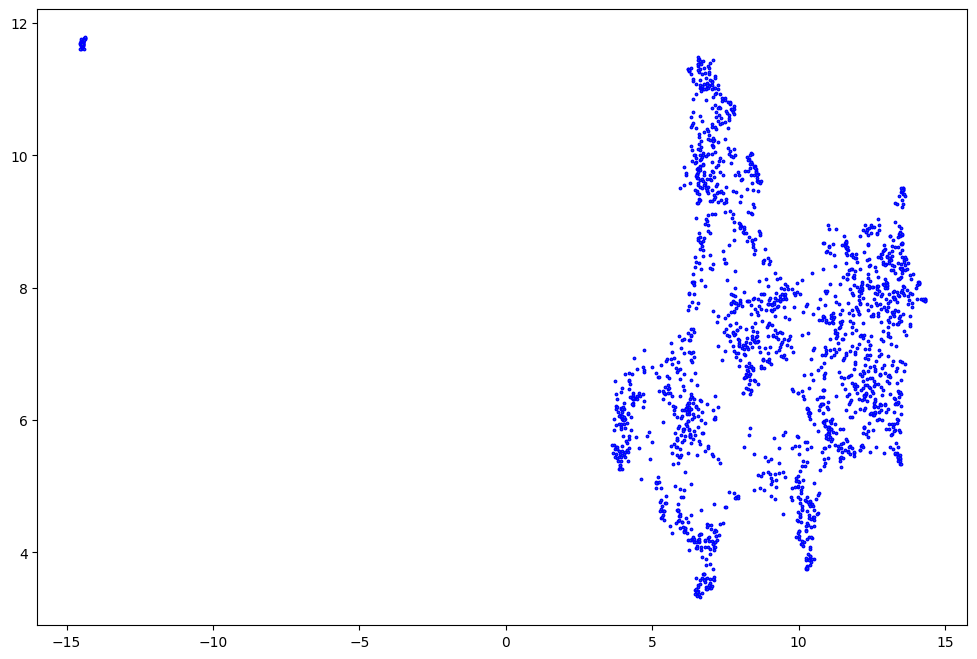

In [ ]:
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], edgecolor='b', s=3)
plt.show()

In [ ]:
X = umaped_vct #w2v_vectors
crit = []

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    crit.append(np.sqrt(kmeans.inertia_))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [ ]:
def elbow_rule(k=2):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    plt.plot(range(2,15), crit, marker='.')
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


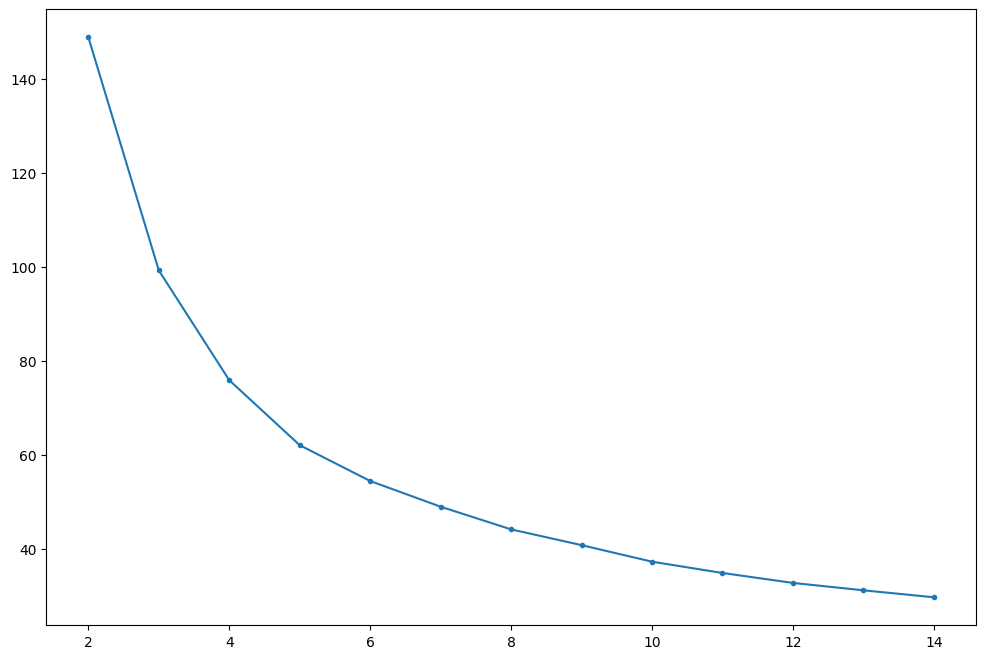

In [ ]:
elbow_rule()

In [ ]:
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.cluster import DBSCAN
from numpy.random import choice

In [ ]:
def cluster_texts_and_draw2(vectors, umaped_vct, k):
    """ Функция кластеризует вектора vectors при помощи kmeans,
        и отображает их на плоскость, используя umaped_vct.
    """

    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans_clasters = kmeans.fit_predict(vectors)
     # Генерируем контрастную карту цветов.
    myclr = ListedColormap(choice(list(sns.xkcd_rgb.values()), max(kmeans_clasters)+1))
    print(max(kmeans_clasters))
    fig, ax = plt.subplots()
    ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=kmeans_clasters, cmap=myclr)
    plt.show()
    return kmeans_clasters

In [ ]:
def show_texts_in_clusters(texts, target, clust_no, text_no):
    """ Функция отображает группировку текстов texts по кластсерам target.
        Выводит не более text_no текстов из первых clust_no кластеров.
    """

    clusters = list(set(target))

    for c in clusters[:clust_no]:
        print('          __ ', c, ' __')
        cntr = 0
        for i, a in enumerate(texts):
            if target[i] == c:
                print(a[:200])
                cntr += 1
                if cntr == text_no:
                    break
        print()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1


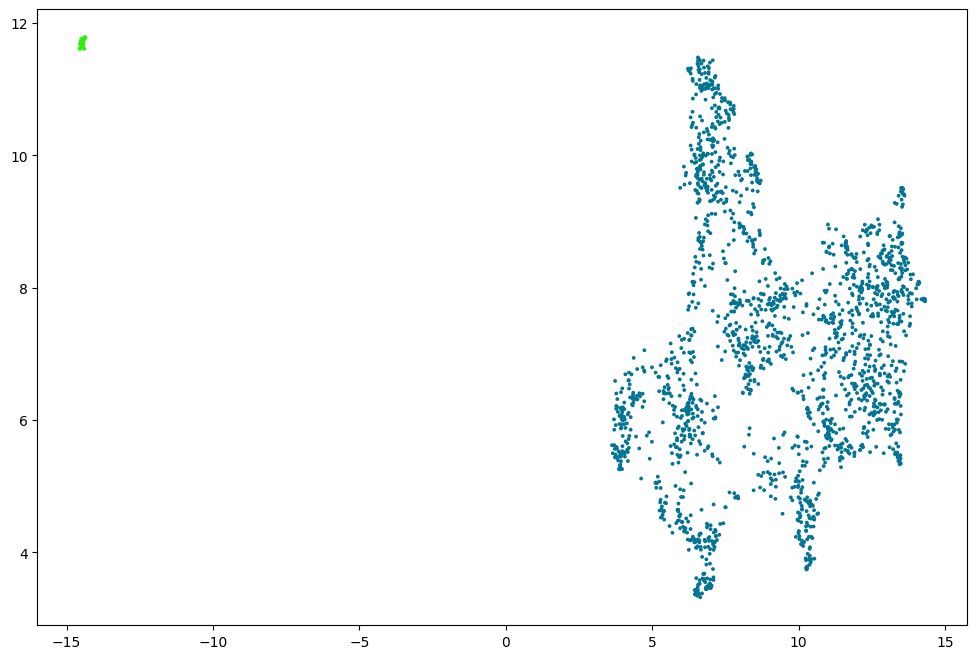

In [ ]:
clusters2 = cluster_texts_and_draw2(umaped_vct, umaped_vct, 2)

In [ ]:
from sklearn.metrics import rand_score
kmeans = KMeans(n_clusters=2, random_state=1).fit(umaped_vct)
ris = rand_score(clusters2, kmeans.labels_)
ris

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1.0

In [ ]:
show_texts_in_clusters(news.categories, clusters2, 2, 10)

          __  0  __
['Новости', 'В мире', 'Статьи', 'Археология']
['Новости', 'В мире', 'Статьи', 'Археология']
['Новости', 'В мире', 'Статьи', 'Медицина']
['Новости', 'В мире', 'Статьи', 'Космос']
['Новости', 'В России', 'Статьи', 'Социология']
['Новости', 'В России', 'Статьи', 'Медицина']
['Международное сотрудничество', 'Новости', 'В России', 'Статьи']
['Новости', 'В России', 'Статьи', 'Память']
['Новости', 'В России', 'Статьи', 'Математика']
['Новости', 'В России', 'РАН', 'Статьи', 'Юриспруденция']

          __  1  __
['Образование', 'Новости', 'В России', 'Память']
['Новости', 'В России', 'Память']
['Новости', 'В России', 'Память']
['Новости', 'В России', 'Память']
['Новости', 'В России', 'научная политика', 'Статьи']
['Новости', 'В России', 'Статьи', 'Территория науки']
['Новости', 'Официально', 'В России', 'Память']
['Образование', 'Новости', 'В России', 'Статьи']
['Новости', 'В мире', 'Статьи', 'Физика']
['Новости', 'Статьи', 'Биология', 'Эксперименты']



In [ ]:
def cluster_texts_and_draw(vectors, umaped_vct, eps):
    """ Функция кластеризует вектора vectors при помощи DBSCAN, используя eps в качестве параметра,
        и отображает их на плоскость, используя umaped_vct.
    """
    # Кластеризуем данные при помощи DBSCAN.
    # Это не значит, что он лучше k-Means, он просто здесь быстрее.
    db = DBSCAN(eps=eps, min_samples=3)
    db_clusters = db.fit_predict(vectors)
     # Генерируем контрастную карту цветов.
    myclr = ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1))
    print(max(db_clusters))
    fig, ax = plt.subplots()
    ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=db_clusters, cmap=myclr)
    plt.show()
    return db_clusters

130


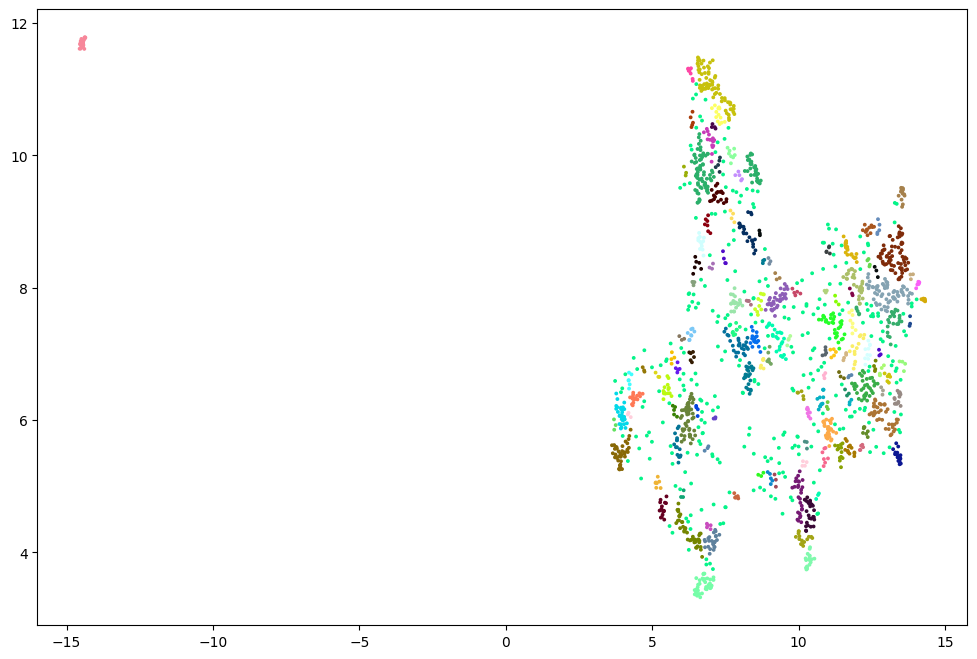

In [ ]:
clusters = cluster_texts_and_draw(umaped_vct, umaped_vct, 0.12)

In [ ]:
show_texts_in_clusters(news.categories, clusters, 10, 3)

          __  0  __
['Новости', 'В мире', 'Статьи', 'Археология']
['Новости', 'В мире', 'Статьи', 'Палеонтология']
['Новости', 'В мире', 'Статьи', 'Археология']

          __  1  __
['Новости', 'В мире', 'Статьи', 'Медицина']
['Новости', 'В России', 'Статьи', 'Медицина']
['Коронавирус', 'Новости', 'В мире', 'Статьи']

          __  2  __
['Новости', 'В мире', 'Статьи', 'Космос']
['Новости', 'В мире', 'Статьи', 'Космос']
['Новости', 'В России', 'Статьи', 'Космос']

          __  3  __
['Новости', 'В России', 'Статьи', 'Социология']
['Новости', 'В мире', 'Статьи', 'История']
['Новости', 'В России', 'Статьи', 'Социология']

          __  4  __
['Новости', 'В России', 'Статьи', 'Медицина']
['Новости', 'В России', 'Статьи', 'Медицина']
['Новости', 'В России', 'Статьи', 'Медицина']

          __  5  __
['Новости', 'В России', 'Статьи', 'Память']
['Новости', 'Награждения', 'В России', 'Статьи']
['Конкурсы', 'Новости', 'В мире', 'Статьи']

          __  6  __
['Новости', 'В России', 'РАН', 'Ст

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)

result = np.column_stack((unique, counts))
print (result)

[[   0 1903]
 [   1   46]]


In [ ]:
Y = []

for i, a in enumerate(X):
    if kmeans.labels_[i]==1:
        Y.append(1.0)
    else:
        Y.append(0.0)

X_ = np.array(X)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_, Y, test_size=0.2)

print(X_train.shape[0], 'train', X_test.shape[0], 'test')

1559 train 390 test


In [ ]:
knn = KNeighborsClassifier(n_neighbors=3, weights='uniform', metric='euclidean')
knn.fit(X_test, Y_test)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [ ]:
y_hat = knn.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, y_hat)
print ("Confusion Matrix : \n", cm)

Confusion Matrix : 
 [[378   0]
 [  0  12]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_hat))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       378
         1.0       1.00      1.00      1.00        12

    accuracy                           1.00       390
   macro avg       1.00      1.00      1.00       390
weighted avg       1.00      1.00      1.00       390



In [ ]:
def calc_prec(y_hat2, y_test):
    prec=0
    for i, j in zip(y_hat2, y_test):
        if i==j:
            prec+=1
    prec/=len(y_test)
    return prec

prec = []
for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform', metric='euclidean')
    knn.fit(X_train, Y_train)
    y_hat2=knn.predict(X_test)
    prec.append(calc_prec(y_hat2, Y_test))

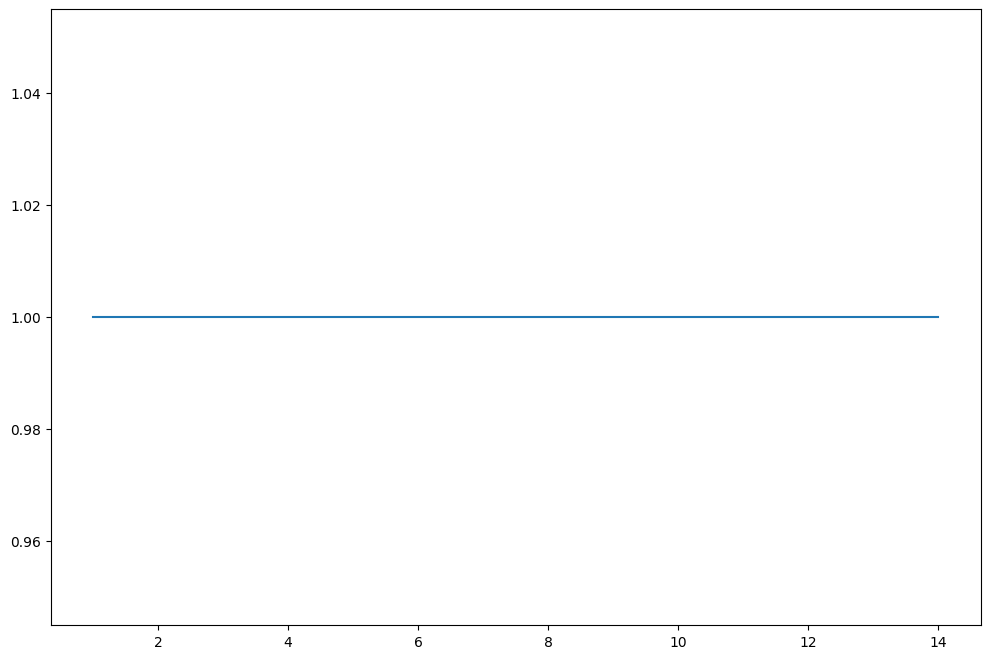

In [ ]:
plt.plot(range(1, 15), prec);